In [2]:
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt


source_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(source_path)

In [116]:
N_max=282
patches=True
input_filename='icdar_train_df_words_sentences_20250522_230307.csv'
huggingface=False
pooling=False # if true in transformer mdoels use pooling, if false only the cls token
custom_transform=False
transform_mode='resize'
save_h5=False
selected_model = 'vitstr_base'
truncation = 'remove head'
running = 'new-laptop'
saved = 'old-laptop'

In [117]:
transform = u_transforms.get_transform(selected_model, use_patches=patches, custom=custom_transform, mode=transform_mode)
model = model_utils.get_model(name=selected_model, mode='truncated', pretrained=True, truncation=truncation)

In [118]:
# Define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ",device)
model = model.to(device)

Device is:  cuda


In [119]:
train_df = pd.read_csv(f"{source_path}\\outputs\\preprocessed_data\\{input_filename}")
train_df=file_IO.change_filename_from_to(train_df, fr=saved, to=running)

In [33]:
train_df.head()

,writer,isEng,same_text,file_name,male,train,index,x,y,x2,y2
0,1,0,0,C:\Users\andre\PhD\Datasets\ICDAR 2013 - Gende...,0,1,0,0,506,821,619
1,1,0,0,C:\Users\andre\PhD\Datasets\ICDAR 2013 - Gende...,0,1,1,0,628,821,739
2,1,0,0,C:\Users\andre\PhD\Datasets\ICDAR 2013 - Gende...,0,1,2,0,1033,821,1139
3,1,0,0,C:\Users\andre\PhD\Datasets\ICDAR 2013 - Gende...,0,1,3,821,506,1642,629
4,1,0,0,C:\Users\andre\PhD\Datasets\ICDAR 2013 - Gende...,0,1,4,821,641,1642,753


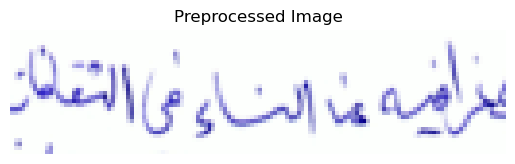

In [120]:
visualization.show_preprocessed_from_csv(train_df,transform,hugging=huggingface,index=1,patches=patches)

In [ ]:
'''
dctocr test

import numpy as np
index=0
# Select an image row from train_df
sample_row = train_df.iloc[index]
image_file = sample_row['file_name']
image = Image.open(image_file).convert("RGB")

# If using patches, crop the patch, else use the whole image
if patches:
    x1, y1, x2, y2 = sample_row['x'], sample_row['y'], sample_row['x2'], sample_row['y2']
    patch = image.crop((x1, y1, x2, y2))
else:
    patch = image.copy()

patch=np.array(patch)
patch_list=[patch]
from doctr.models.preprocessor import PreProcessor
transform=PreProcessor(
        (32, 128),
        batch_size=1,
        mean=(0.798, 0.785, 0.772),
        std=(0.264, 0.2749, 0.287),
        #preserve_aspect_ratio=True,
        #symmetric_pad=True,
    )
patch=transform(patch_list)
patch = patch[0].squeeze(0)
img_np = patch.permute(1, 2, 0).cpu().numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

plt.imshow(img_np)
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()'''


'import numpy as np\nindex=0\n# Select an image row from train_df\nsample_row = train_df.iloc[index]\nimage_file = sample_row[\'file_name\']\nimage = Image.open(image_file).convert("RGB")\n\n# If using patches, crop the patch, else use the whole image\nif patches:\n    x1, y1, x2, y2 = sample_row[\'x\'], sample_row[\'y\'], sample_row[\'x2\'], sample_row[\'y2\']\n    patch = image.crop((x1, y1, x2, y2))\nelse:\n    patch = image.copy()\n\npatch=np.array(patch)\npatch_list=[patch]\nfrom doctr.models.preprocessor import PreProcessor\ntransform=PreProcessor(\n        (32, 128),\n        batch_size=1,\n        mean=(0.798, 0.785, 0.772),\n        std=(0.264, 0.2749, 0.287),\n        #preserve_aspect_ratio=True,\n        #symmetric_pad=True,\n    )\npatch=transform(patch_list)\npatch = patch[0].squeeze(0)\nimg_np = patch.permute(1, 2, 0).cpu().numpy()\nimg_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())\n\nplt.imshow(img_np)\nplt.title("Preprocessed Image")\nplt.axis(\'off\')\np

In [121]:
i=0
output=compute_output(model, device, transform, train_df.iloc[i], huggingface, patches)

In [112]:
print("Output shape: ", output.shape)

Output shape:  torch.Size([1, 768])


In [122]:
model.eval()

if save_h5:
    import h5py
    import numpy as np
    import shutil
    icdar_path=train_df['file_name'][0]
    icdar_path = icdar_path[:icdar_path.lower().find("unzipped")].rsplit("\\", 1)[0] + "\\"
    # Define the directory and file paths
    h5_directory_name = "extracted_representations_full"
    h5_save_path=icdar_path+h5_directory_name
    # Open the file in append mode
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    h5_file_name = h5_save_path+f"\\representations_{selected_model}_{truncation}_{timestamp}.h5"
    with h5py.File(h5_file_name, "a") as f:
        model.eval()
        for index,t in train_df.iterrows():
            if huggingface:
                output = compute_output(model, device, transform, t, huggingface, patches)
            else:
                output = compute_output(model, device, transform, t, huggingface, patches)
            #print(output)
            # Convert index to string key (e.g., "0001")
            key = f"{index:06d}"
            # Store with compression (optional)
            rep_np = output.squeeze(0).detach().cpu().numpy()
            f.create_dataset(key, data=rep_np, compression="gzip")
            if index % 100 == 0:
                print(f"Processed {index} images, out of {len(train_df)}")
    #close the file
    f.close()
# Initialize a dictionary to store new feature columns
else:
    new_features = {}

    for index,t in train_df.iterrows():
        if huggingface:
            if pooling:
                print("Pooling is not implemented yet")
                break
            else:
                output = compute_output(model, device, transform, t, huggingface, patches)[:,0,:]
        else:
            output = compute_output(model, device, transform, t, huggingface, patches)
        for i, value in enumerate(output.squeeze().tolist()):
            column_name = f"f{i+1}"
            if column_name not in new_features:
                new_features[column_name] = []
            new_features[column_name].append(value)
        if index % 100 == 0:
            print(f"Processed {index} images, out of {len(train_df)}")

        
    # Add the new features to the DataFrame in one operation
    new_features_df = pd.DataFrame(new_features)
    train_df = pd.concat([train_df.reset_index(drop=True), new_features_df], axis=1)

Processed 0 images, out of 10152
Processed 100 images, out of 10152
Processed 200 images, out of 10152
Processed 300 images, out of 10152
Processed 400 images, out of 10152
Processed 500 images, out of 10152
Processed 600 images, out of 10152
Processed 700 images, out of 10152
Processed 800 images, out of 10152
Processed 900 images, out of 10152
Processed 1000 images, out of 10152
Processed 1100 images, out of 10152
Processed 1200 images, out of 10152
Processed 1300 images, out of 10152
Processed 1400 images, out of 10152
Processed 1500 images, out of 10152
Processed 1600 images, out of 10152
Processed 1700 images, out of 10152
Processed 1800 images, out of 10152
Processed 1900 images, out of 10152
Processed 2000 images, out of 10152
Processed 2100 images, out of 10152
Processed 2200 images, out of 10152
Processed 2300 images, out of 10152
Processed 2400 images, out of 10152
Processed 2500 images, out of 10152
Processed 2600 images, out of 10152
Processed 2700 images, out of 10152
Proc

In [60]:
train_df.head()

,writer,isEng,same_text,file_name,male,train,index,x,y,x2,...,f2039,f2040,f2041,f2042,f2043,f2044,f2045,f2046,f2047,f2048
0,1,0,0,C:\Users\andre\PhD\Datasets\ICDAR 2013 - Gende...,0,1,0,1476,984,1722,...,0.527016,0.151143,0.052378,0.075106,0.139401,0.048882,0.001788,0.026471,0.000000,0.181974
1,1,0,0,C:\Users\andre\PhD\Datasets\ICDAR 2013 - Gende...,0,1,1,1722,984,1968,...,0.309595,0.589577,0.028709,0.582213,0.083180,0.102900,0.087747,0.212132,0.081255,0.138128
2,1,0,0,C:\Users\andre\PhD\Datasets\ICDAR 2013 - Gende...,0,1,2,984,738,1230,...,0.600109,0.000000,0.038002,0.021267,0.020812,0.017402,0.129796,0.022709,0.002241,0.136042
3,1,0,0,C:\Users\andre\PhD\Datasets\ICDAR 2013 - Gende...,0,1,3,738,738,984,...,0.117669,0.031779,0.016809,0.109753,0.091854,0.043292,0.031907,0.400175,0.235237,0.021168
4,1,0,0,C:\Users\andre\PhD\Datasets\ICDAR 2013 - Gende...,0,1,4,492,738,738,...,0.210229,0.026293,0.002361,0.008674,0.032707,0.018616,0.001296,0.097478,0.000522,0.106027


In [ ]:
'''from utils.dataframes import CustomImageDataset, CustomPatchDataset
from torch.utils.data import Dataset,DataLoader, random_split
source_path="D:\\burtm\\Visual_studio_code\\PD_related_projects"
train_df = pd.read_csv(f"{source_path}\\outputs\\preprocessed_data\\{input_filename}")
model.eval()
dataset = CustomPatchDataset(train_df[train_df['writer']<=N_max] ,
                                        label_column='male', transform=transform, huggingface=huggingface)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
new_features = {}

for idx, batch in enumerate(dataloader):
    patch = batch['image'].to(device)
    output = model(pixel_values=patch)
    cls_token_output = output.last_hidden_state[:, 0, :]  # Extract the CLS token
    for i, value in enumerate(cls_token_output.squeeze().tolist()):
        column_name = f"f{i+1}"
        if column_name not in new_features:
            new_features[column_name] = []
        new_features[column_name].append(value)
    if idx % 100 == 0:
        print(f"Processed {idx * batch_size} images, out of {len(dataset)}")

# Convert the dictionary to a DataFrame
new_features_df = pd.DataFrame(new_features)'''

Processed 0 images, out of 5640



KeyboardInterrupt



In [123]:
#source_path="D:\\burtm\\Visual_studio_code\\PD_related_projects"
output_dir = os.path.join(source_path, "outputs", "preprocessed_data")
if save_h5:
    output_file = h5_file_name
else:
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = os.path.join(output_dir, f"icdar_EXTRACTED_train_df_{selected_model}_{timestamp}.csv")
    train_df.to_csv(output_file, index=False)
    print(f"Dataframe saved to {output_file}")

Dataframe saved to c:\Users\andre\VsCode\PD related projects\gender_detection\outputs\preprocessed_data\icdar_EXTRACTED_train_df_vitstr_base_20250524_004825.csv


In [124]:
# Example usage:
LOG_FILE = output_dir+"\\file_metadata_log.json"
print(f"Log file path: {LOG_FILE}")
print(f"Output file path: {output_file}")
file_IO.add_or_update_file(
    output_file, LOG_FILE,
    custom_metadata={
        #"seed": seed,
        "source_file": input_filename,
        "model": selected_model,
        "pooling": pooling,
        "custom transform": custom_transform,
        "save_h5": save_h5,
        "truncation": truncation,
        "transform_mode": transform_mode,
        "description": '''
        testing the vitstr model with the sentence level dataset''' 
    }
)

Log file path: c:\Users\andre\VsCode\PD related projects\gender_detection\outputs\preprocessed_data\file_metadata_log.json
Output file path: c:\Users\andre\VsCode\PD related projects\gender_detection\outputs\preprocessed_data\icdar_EXTRACTED_train_df_vitstr_base_20250524_004825.csv
Updated log for icdar_EXTRACTED_train_df_vitstr_base_20250524_004825.csv


In [63]:
file_IO.read_metadata(
    output_file,
    log_path=LOG_FILE
)

Metadata for icdar_EXTRACTED_train_df_resnet50_20250523_175257.csv:
full_path: c:\Users\andre\VsCode\PD related projects\gender_detection\outputs\preprocessed_data\icdar_EXTRACTED_train_df_resnet50_20250523_175257.csv
size_bytes: 223055886
created: 2025-05-23T17:52:57.692738
modified: 2025-05-23T17:53:14.492980
accessed: 2025-05-23T17:53:14.492980
source_file: icdar_train_df_patches_20250521_120324.csv
model: resnet50
pooling: False
custom transform: False
save_h5: False
truncation: remove head
transform_mode: 
description: 
        testing resnet50 model on small patches datasets (1/100 the area of the original image)


In [15]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_path=source_path+f"\\outputs\\preprocessed_data\\icdar_EXTRACTED_trocr_stage_1_10blocks_{timestamp}.csv"
train_df.to_csv(file_path, index=False)
print(f"File saved: {file_path}")

File saved: D:\burtm\Visual_studio_code\PD_related_projects\outputs\preprocessed_data\icdar_EXTRACTED_trocr_stage_1_10blocks_20250509_153553.csv


# easy access

In [63]:
def reload_modules():
    import importlib
    import utils.data_loading as data_loading
    import utils.visualization as visualization
    import utils.dataframes as dataframes
    import utils.utils_transforms as u_transforms
    import utils.training_utils as training_utils
    import utils.model_utils as model_utils
    import utils.file_IO as file_IO
    
    importlib.reload(file_IO)
    importlib.reload(data_loading)
    importlib.reload(visualization)
    importlib.reload(dataframes)
    importlib.reload(u_transforms)
    importlib.reload(model_utils)
    importlib.reload(training_utils)

    return data_loading, visualization, dataframes, u_transforms, training_utils, model_utils, file_IO
data_loading, visualization, dataframes, u_transforms, training_utils, model_utils, file_IO = reload_modules()

In [64]:
def compute_output(model, device, transform, t, huggingface, patches):
    image_file = t['file_name']
    image = Image.open(image_file).convert("RGB")
    if patches:
        x1 = t['x']
        y1 = t['y']
        x2 = t['x2']
        y2 = t['y2']
        patch = image.crop((x1, y1, x2, y2))
    else:
        patch = image.copy()
    if huggingface:
        # the transform is actually an huggingface processor in this case
        inputs = transform(images=patch, return_tensors="pt")
        # Remove batch dimension from inputs
        patch = inputs['pixel_values'].squeeze()
    else:
        patch = transform(patch)
    patch = patch.to(device)
    output = model(patch.unsqueeze(0))
    return output

In [65]:
def show_image(transform, t, huggingface, patches):
    image_file = t['file_name']
    image = Image.open(image_file).convert("RGB")
    if patches:
        x1 = t['x']
        y1 = t['y']
        x2 = t['x2']
        y2 = t['y2']
        patch = image.crop((x1, y1, x2, y2))
    else:
        patch = image.copy()

    # Show original image/patch
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(patch)
    plt.title("Original")
    plt.axis('off')

    if huggingface:
        inputs = transform(images=patch, return_tensors="pt")
        transformed_patch = inputs['pixel_values'].squeeze()
        # Convert tensor to numpy for visualization
    else:
        transformed_patch = transform(patch)
    
    img_np = transformed_patch.permute(1, 2, 0).cpu().numpy()
    # Normalize if needed
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    plt.subplot(1, 2, 2)
    plt.imshow(img_np)
    plt.title("Transformed")
    plt.axis('off')
    plt.show()

# save to h5

In [ ]:
with h5py.File(save_path+"\\representations.h5", "r") as f:
    rep_42 = f["000042"][:]  # Load representation for index 42
print(rep_42)